%\begin{center}
%\begin{equation}
%j_{ff,\nu}=\frac{8}{3}(\frac{2\pi}{3})^{1/2}g_{ff,i}\frac{e^6}{m^{2}_{e}c^{3}}
%(\frac{m_{e}}{kT})^{1/2}e^{\frac{-h\nu{}}{kT}}n_{e}Z^{2}_{i}n_{i}
%\end{equation}
%\end{center}

In [2]:
import os
import astropy
import astropy.io.fits as fits
import astropy.units as u
import numpy as np
import healpy as hp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
%matplotlib inline

# Make Microwave Foreggrounds demo SED:

$j_{ff,\nu}=\frac{8}{3}(\frac{2\pi}{3})^{1/2}g_{ff,i}\frac{e^6}{m^{2}_{e}c^{3}}(\frac{m_{e}}{kT})^{1/2}e^{\frac{-h\nu{}}{kT}}n_{e}Z^{2}_{i}n_{i}$

where g_{ff,i} is the Gaunt factor (subject to its own uncertainties)

### Import WMAP data

In [3]:
wmaplist = ['K','Ka','Q','V','W']
wmapfreqlist = [23,33,41,61,94]

wmapframe = pd.DataFrame()

for i in range(0,len(wmaplist)):
    
    band = wmaplist[i]
    freq = wmapfreqlist[i]
    
    wmapfilen = '../Data/raw/WMAP/wmap_band_imap_r9_5yr_{}_v3.fits'.format(band)

    
    map512 = hp.read_map(wmapfilen
                         , nest=True)
    
    map256 = hp.ud_grade(map512, 
                      nside_out = 256, 
                      order_in = 'NESTED', 
                      order_out = 'NESTED',
                      pess=True)
    
    wmapframe[freq] = map256

NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/work1/users/aaronb/Softbrary/Anaconda/lib/python2.7/site-packages/healpy/fitsfunc.py:326: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  "assume {}".format(schm))


NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


### Import Planck Data

In [4]:

planckpcadir = '/work1/users/aaronb/Codebrary/Python/Projects/PlanckPCA/data/planck'
maplist = os.listdir(planckpcadir)

mapframe = pd.DataFrame()
planckfreqlist = [100,143,217,353,545,857,30,44,70]
for i in range(0,len(maplist)):
    map = maplist[i]
    freq = planckfreqlist[i]
    mapframe[freq] = hp.ud_grade(hp.read_map(planckpcadir+"/"+map,nest=True), 
                                       nside_out = 256, 
                                       order_in = 'NESTED', 
                                       order_out = 'NESTED')

NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


### Convert WMAPs to K from $\mu$K

In [5]:
mwframe = (wmapframe/1000).join(mapframe)

### Convert HFI 545 and 857 to K_CMB from Mjy/sr

In [6]:
mwframe[857] /= 2.27

In [7]:
mwframe[545] /= 58.04

### Chose coords for obs example. Calculate emission components. Import spdust template.

In [8]:
glon = 353.05
glat = 16.90

pixnum = hp.ang2pix(256,
                    glon,
                    glat,
                    lonlat=True, 
                     nest=True)

# Constants
## CMB
T_cmb  = 2.7255
h      = astropy.constants.h
k_B    = astropy.constants.k_B
A_cmb  = 1e-3
## Dust
beta   = 1.7

# Templates
nu     = np.linspace(0.1,1000,1000)

ame_hdu = fits.open('../Data/raw/COM_CompMap_AME-commander_0256_R2.00.fits.gz')
#ame_hdu.info()
spdust_temp = pd.DataFrame(ame_hdu[3].data)
f_sd   = spdust_temp.copy()

# Calculations

nu_hz  = nu.copy()*1e9
x_cmb  = (h*nu_hz*u.Hz)/(k_B*T_cmb*u.K)
g      = ((np.exp(x_cmb)-1)**2)/((x_cmb**2)*np.exp(x_cmb))
cmb    = A_cmb/g

# Emmission components

ff     = (nu**(-0.118))*1e-4
thdust = (nu**(4+beta))*1e-15
sync   = (nu**-1)*1e-4
spdust = np.interp(nu, f_sd.NU, f_sd.J_NU)*0.3e15
total  = ff + sync + spdust +thdust +cmb

### Make the plot

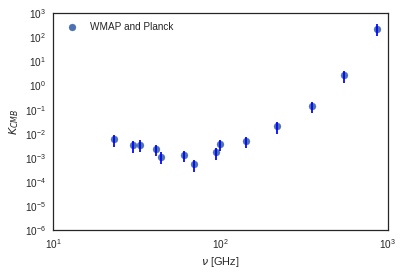

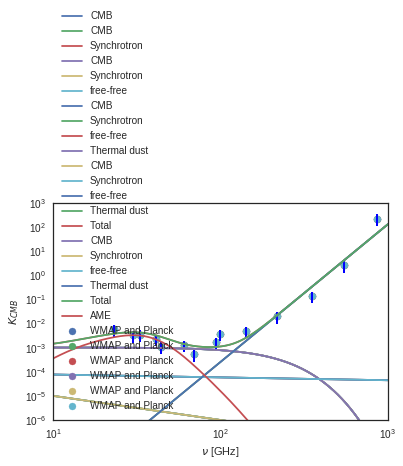

In [33]:
def makeExampleSED():
    with sb.axes_style("white"):
        #plt.figure(figsize=(8,6))
        plt.xscale('log')
        plt.yscale('log')
        plt.xlim(1e1, 1e3)
        plt.ylim(1e-6, 1e3)
        plt.ylabel('$K_{CMB}$')
        plt.xlabel('$\\nu$ [GHz]')
        
        layers = [cmb, sync, ff, thdust, total, spdust]
        labels = ["CMB","Synchrotron", "free-free","Thermal dust","Total","AME"]
        
        
        plt.scatter( mwframe.columns, 
                     mwframe.iloc[pixnum], 
                     label = "WMAP and Planck")
        
        plt.errorbar(mwframe.columns, 
                     mwframe.iloc[pixnum],
                     yerr=mwframe.iloc[pixnum]*0.5,
                     fmt=None,
                    label=None,
                    color='b', 
                     capthick=2)
        plt.legend()
        plt.show()
        plt.savefig('../Plots/ch_intro/mw_foregrounds_demo_rOph_sub0.pdf')
        
        for i in range(0,len(layers)):
            
            

            plt.scatter( mwframe.columns, 
                         mwframe.iloc[pixnum], 
                         label = "WMAP and Planck")

            plt.errorbar(mwframe.columns, 
                         mwframe.iloc[pixnum],
                         yerr=mwframe.iloc[pixnum]*0.5,
                         fmt=None,
                        label=None,
                        color='b', 
                         capthick=2)
        
            plt.xscale('log')
            plt.yscale('log')
            plt.xlim(1e1, 1e3)
            plt.ylim(1e-6, 1e3)
            plt.ylabel('$K_{CMB}$')
            plt.xlabel('$\\nu$ [GHz]')
            
            for j in range(0,i+1):
                plt.plot(nu, layers[j], label = labels[j])
                
            plt.legend()
            
            plt.savefig('../Plots/ch_intro/mw_foregrounds_demo_rOph_sub{}.pdf'.format(i+1))
            plt.show()
        
        plt.savefig('../Plots/ch_intro/mw_foregrounds_demo_rOph.pdf')
        
makeExampleSED()

In [10]:
import pickle
with open('../Data/maps_nest.pickle') as f:  # Python 3: open(..., 'rb')
    coords, planck_bb, planck_mw,  phot, phot_modesub, phot_mpsub = pickle.load(f) 

In [11]:
import astropy.units as u
import astropy.constants as c

In [12]:
# Calculations
from astropy.modeling.blackbody import blackbody_lambda, blackbody_nu

wavelengths = np.linspace(1, 1000, 1000) * u.micron
temperature = 18 * u.K

with np.errstate(all='ignore'):
    flux_lam = blackbody_lambda(wavelengths, temperature)

#print flux_lam

#irframe = phot[[u'A9', u'I12', u'A18', u'I25', u'I60', u'A65', u'A90', u'I100', u'A140',
#       u'A160',]].copy()

phot_mpsub.columns = [9, 12, 18, 25, 60, 65, 90, 100, 140, 160, 345, 550]

#irframe.columns = (np.array([9, 12, 18, 25, 60, 65, 90, 100, 140, 160, 345, 550])*1e-6)/c.c

(0.1, 3000)

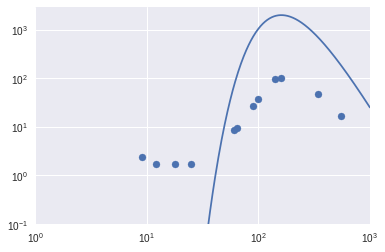

In [13]:

glon = 139
glat = -1

pixnum = hp.ang2pix(256,
                    glon,
                    glat,
                    lonlat=True, 
                     nest=True)

plt.scatter( phot_mpsub.columns, 
                 phot_mpsub.iloc[pixnum], 
                 label = "IR Dust Emission")
plt.plot(wavelengths, (flux_lam/flux_lam.max())*2000)
plt.xlim(1,1000)
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.1, 3000)

In [14]:
irframe.columns

NameError: name 'irframe' is not defined

# References

<mark> <b>The bib file biblio.bib was not found

</b> </mark>(<a id="cit-ishihara10" href="#call-ishihara10">?</a>) !! _This reference was not found in biblio.bib _ !!

(<a id="cit-doi15" href="#call-doi15">1</a>) !! _This reference was not found in biblio.bib _ !!

